# Team Lovelace : #TODO (ecrire le titre) <img src="../Data/Images/LinkedIn_logo_initials.png" width="25">

Welcome to our project notebook for Milestone P2! In this phase, our team has worked on refining our project proposal and conducting preliminary analyses to set the stage for a successful data exploration and analysis journey. 

Our project aims to analyze the careers of actors present in our dataset. In this milestone, we delve into initial analyses and data handling tasks, ensuring that our proposed project is feasible given the available datasets.

## Imports


In [1]:
%load_ext autoreload

In [125]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, pearsonr
from tqdm import tqdm
from rapidfuzz import fuzz
from matplotlib import colors

from helpers import *

import warnings

# Ignoring warnings to improve code readability
warnings.filterwarnings("ignore")

# Resetting Matplotlib default settings
plt.rcdefaults()

# Set the maximum number of rows to display
pd.set_option('display.max_rows', 20)

%autoreload 2

## Loading Datasets

In [3]:
# Setting the paths to the data folders
DATA_FOLDER = "../Data/"
CMU_PATH = DATA_FOLDER + "MovieSummaries/"
IMDB_PATH = DATA_FOLDER + "IMDb/"
OMDB_PATH = DATA_FOLDER + "OMDb/"
BUDGET_PATH = DATA_FOLDER + "Budget/"
OSCARS_PATH = DATA_FOLDER + "Oscars/"

In [4]:
# Reading CMU Movie & Character metadata
cmu_movies_raw = pd.read_csv(CMU_PATH + "movie.metadata.tsv", sep="\t", )
cmu_characters_raw = pd.read_csv(CMU_PATH + "character.metadata.tsv", sep="\t")

# Reading IMDb basics and ratings data
imdb_movies_raw = pd.read_csv(
    IMDB_PATH + "title.basics.tsv.gz", sep="\t", compression="gzip"
)
imdb_ratings_raw = pd.read_csv(
    IMDB_PATH + "title.ratings.tsv.gz", sep="\t", compression="gzip"
)

# Reading movie data that was fetched using the OMDb API (done in omdbAPI.ipynb)
omdb_raw = pd.read_csv(
    OMDB_PATH + "omdb.csv"
)

# Reading movie budget data
budget_raw = pd.read_csv(
    BUDGET_PATH + "movies_metadata.csv.zip", compression="zip",
)

# Reading Oscars data
oscars_raw = pd.read_csv(
    OSCARS_PATH + "the_oscar_award.csv",
)


# TODO Import other dataset (Don't forget to add comments as above)

### Renaming Columns

Both CMU datasets, `cmu_movies_raw` and `cmu_characters_raw`, initially lacked column names (#TODO ajouter les noms des autres datasets entre `...` si nécessaires). To address this, we have provided names in the cell below. For the CMU dataset, you can refer to the descriptions of each column [here](http://www.cs.cmu.edu/~ark/personas/). (#TODO pareil mettre les liens pour les autres datasets)


In [5]:
cmu_movies_raw.columns = [
    "wikiID",
    "fbID",
    "movieName",
    "releaseDate",
    "boxOffice",
    "runtime",
    "languages",
    "countries",
    "genres",
]

cmu_characters_raw.columns = [
    "wikiID",
    "fbID",
    "releaseDate",
    "characterName",
    "actorDOB",
    "actorGender",
    "actorHeight",
    "actorEthnicity",
    "actorName",
    "ageAtMovieRelease",
    "fbCharacterMap",
    "fbCharacterID",
    "fbActorID",
]

cmu_movies_raw.drop(columns="wikiID", inplace=True)  #TODO expliquer pk on drop au dessus
cmu_characters_raw.drop(columns="wikiID", inplace=True)
#TODO add les noms ici si necessaire pour les autres datasets

To ensure consistency in column names across datasets, we have renamed some columns in the other datasets (to match the conventions of the CMU dataset) in the cell below.

In [6]:
imdb_movies_raw.rename(
    columns={
        "tconst": "imdbID",
        "primaryTitle": "movieName",
        "startYear": "releaseYear",
        "runtimeMinutes": "runtime",
    },
    inplace=True
)

imdb_ratings_raw.rename(
    columns={
        "tconst": "imdbID",
    },
    inplace=True
)

oscars_raw.rename(
    columns={
        "year_film": "releaseYear",
        "year_ceremony": "yearCeremony",
        "name": "actorName",
        "film": "movieName",
    },
    inplace=True
)

omdb_raw = omdb_raw[
    ['Rated', 'Director', 'Writer', 'Actors', 'Plot', 'Language', 'Country', 'Awards', 'Poster', 'Ratings', 'Metascore',
     'imdbID']].rename(
    columns={
        "Rated": "MPARating",
        "Director": "director",
        "Writer": "writer",
        "Actors": "actors",
        "Plot": "plot",
        "Language": "languages",
        "Country": "countries",
        "Awards": "awards",
        "Poster": "poster",
        "Ratings": "allRatings",
        "Metascore": "metascore",
    }
)

budget_raw = budget_raw[["budget", "popularity", "imdb_id"]].rename(
    columns={
        "imdb_id": "imdbID",
    }
)

# TODO rename les columns des autres datasets si nécessaire

## Merging Datasets

Before merging the datasets, it is important to clean and standardize the column formats for the columns we intend to merge on. To facilitate this process, we create copies of our raw dataframes. This ensures that we don't need to reload them if we want to start the cleaning process from scratch.

In [197]:
cmu_movies = cmu_movies_raw.copy()
cmu_characters = cmu_characters_raw.copy()

imdb_movies = imdb_movies_raw.copy()
imdb_ratings = imdb_ratings_raw.copy()

omdb = omdb_raw.copy()

budget = budget_raw.copy()

oscars = oscars_raw.copy()

### Extracting ethnicities

In the original dataset, ethnicities are represented as Freebase IDs. Such IDs are difficult to interpret, so we replaced them by their real name. The map used to convert IDs to the name of the ethnicity is extracted from the full freebase database in `Code/extract-ethnicities.ipynb`.

In [198]:
# Read the map that converts ethnicities
map_ethnicities = eval('\n'.join(open("../Data/map-ethnicities.txt").readlines()))

# Apply the conversion on the dataset
cmu_characters.actorEthnicity = cmu_characters.actorEthnicity.apply(
    lambda eth: map_ethnicities.get("m." + eth[3:] if type(eth) == type("") else "", None))

cmu_characters.actorEthnicity.value_counts()

actorEthnicity
Indian people                            16351
African American                         10159
Jewish people                            10121
White people                              2307
White American                            2250
                                         ...  
Lebanese people in the United Kingdom        1
Métis people                                 1
Ossetians                                    1
Sinhala- Tamil                               1
Georgians                                    1
Name: count, Length: 249, dtype: int64

### Cleaning columns `movieName` & `actorName`

As we want to merge the `cmu_movies` and `cmu_characters` datasets on the `movieName` column (as we don't have matching IDs for both), we first standardize the movie titles by removing accents, special characters, extra spaces and converting to lowercase to increase the likelihood of finding a match. 
Likewise, we do the same thing for the actor names in `cmu_characters` and the `oscars` dataset.

In [199]:
# pre-filtering IMDb movies
# Keep only movies and shorts
imdb_movies = imdb_movies[imdb_movies['titleType'].isin(['movie', 'short', 'tvMovie', 'tvShort'])]
# Remove data for movies with no name
imdb_movies.dropna(subset='movieName', inplace=True)
oscars.dropna(subset='movieName', inplace=True)
# Likewise for actors with no name
cmu_characters.dropna(subset='actorName', inplace=True)

In [200]:
# Standardize movie titles and actor names by removing accents, special characters, extra spaces and converting to lowercase
cmu_movies['movieNameStd'] = cmu_movies['movieName'].apply(standardize_str)
imdb_movies['movieName'] = imdb_movies['movieName'].apply(standardize_str)
imdb_movies.rename(columns={'movieName':'movieNameStd'}, inplace=True)
oscars['movieName'] = oscars['movieName'].apply(standardize_str)

oscars['actorName'] = oscars['actorName'].apply(standardize_str)
oscars.rename(columns={'actorName': 'actorNameStd'}, inplace=True)
cmu_characters['actorNameStd'] = cmu_characters['actorName'].apply(standardize_str)

### Cleaning column `releaseDate`

The `cmu_movies` and `cmu_characters` dataset exhibit variable date formats, with some entries providing day, month, and year, while others only contain the year. To enhance clarity and facilitate analysis, we've decided to split the `releaseDate` column into separate columns for `releaseMonth` and `releaseYear`. In contrast, the `imdb_movies` and `oscars` datasets provides release dates in the year-only format.

In [201]:
# Cmu movies & characters
# Months
cmu_movies["releaseMonth"] = pd.to_datetime(
    cmu_movies["releaseDate"], errors="coerce", dayfirst=True
).dt.month
cmu_characters["releaseMonth"] = pd.to_datetime(
    cmu_characters["releaseDate"], errors="coerce", yearfirst=True
).dt.month
# Year
cmu_movies["releaseYear"] = pd.to_datetime(
    cmu_movies["releaseDate"], errors="coerce", format="mixed", dayfirst=True
).dt.year
cmu_characters["releaseYear"] = pd.to_datetime(
    cmu_characters["releaseDate"], errors="coerce", format="mixed", dayfirst=True
).dt.year

# Drop releaseDate column
cmu_movies.drop(columns=["releaseDate"], inplace=True)
cmu_characters.drop(columns=["releaseDate"], inplace=True)

# IMDb & Oscars
imdb_movies["releaseYear"] = pd.to_datetime(
    imdb_movies["releaseYear"], errors="coerce", format="%Y"
).dt.year

oscars["releaseYear"] = pd.to_datetime(
    oscars["releaseYear"], errors="coerce", format="%Y"
).dt.year

In [202]:
# drop movie with same title and release date to avoid issues when merging
cmu_movies.drop_duplicates(subset=["movieNameStd", "releaseMonth", "releaseYear"], inplace=True)
imdb_movies.drop_duplicates(subset=["movieNameStd", "releaseYear"], inplace=True)

### Cleaning column `runtime`

The `runtime` column for the `imdb_movies` dataset contains non-numerical values (such as '\N') instead of 'NaN'.

In [203]:
imdb_movies["runtime"] = pd.to_numeric(imdb_movies["runtime"], errors="coerce")

#TODO other columns to clean pour merger??

### Cleaning budget dataset

In [217]:
# Make sure all budget entries are numeric (or null)
budget["budget"] = pd.to_numeric(budget["budget"], errors="coerce")
# Remove duplicate IMDb IDs
budget.drop_duplicates(subset='imdbID', inplace=True)
# Replace all zero budget entries to nan
budget.loc[budget['budget'] == 0, 'budget'] = np.nan
# Drop null budget and imdbID entries to avoid issues when merging
budget.dropna(subset=['budget', 'imdbID'], inplace=True)

### Merging

In the following cell, we perform two left merges:

1. **CMU Movies and IMDb Merged Data:**
   - We merge the `cmu_movies` dataset with the merged IMDb dataset based on the common columns `["movieName", "releaseYear", "runtime"]`. The resulting DataFrame, named `movies_merged`, contains combined information from both datasets, with column suffixes "Cmu" for columns from the CMU dataset and "Imdb" for columns from the IMDb dataset.

2. **CMU Characters and Oscars:**
   - We merge the `cmu_characters` dataset with the `oscars` dataset based on the common columns `["actorName", "releaseYear", "movieName"]` using a left join.
   

#TODO other merge to do. Adapter les textes au dessus et il faut max deux datasets. un qui s'appelle actors et l'autre movies




### Merging

In the following cells, we will merge our datasets together in order to populate the CMU movies and characters dataframes with information from the IMDb/Budget/Oscars datasets.

1. **CMU Movies and IMDb Merged Data:**
   - 

In [205]:
# Merging IMDb movies with IMDb ratings
imdb = pd.merge(imdb_movies, imdb_ratings, how='left', on='imdbID')

In [207]:
# Merging CMU movies with IMDb movies

# Using rapidfuzz library to perform fast fuzzy matching between the movie titles
# Group the imdb dataframe by releaseYear to speed up the search
grouped_imdb = imdb.groupby('releaseYear')
# Enable tqdm pandas integration
tqdm.pandas(desc="Retrieving best matches")
# Compute the best match for each title in CMU movies with a similarity threshold of 95
cmu_movies['matched_title'] = cmu_movies.progress_apply(get_best_match, args=(grouped_imdb,), scorer=fuzz.WRatio,
                                                        threshold=95, axis=1)

# Perform the merge on the matched titles and releaseYear
movies_merged = pd.merge(cmu_movies, imdb, left_on=['matched_title', 'releaseYear'],
                         right_on=['movieNameStd', 'releaseYear'], how='left', suffixes=['Cmu', 'Imdb'])

# To improve the accuracy of the merge, we filter out IMDb data for movies where runtime doesn't match (with tolerance)
runtime_tol = 5  # Allow for 5 minutes of leeway in runtime between IMDb and CMU

# When only one of the runtimes is nan, use the other
movies_merged['runtimeCmu'] = np.where(
    # If runtimeCmu is nan but runtimeImdb is not, use runtimeImdb else keep runtimeCmu
    pd.isna(movies_merged['runtimeCmu']) & pd.notna(movies_merged['runtimeImdb']),
    movies_merged['runtimeImdb'],
    movies_merged['runtimeCmu']
)

# Identify rows where both runtimes are not NaN and the difference is not within tolerance
mask = pd.notna(movies_merged['runtimeCmu']) & pd.notna(movies_merged['runtimeImdb']) & (
        abs(movies_merged['runtimeCmu'] - movies_merged['runtimeImdb']) > runtime_tol)

# Remove IMDb data when the runtimes are not within tolerance
movies_merged.loc[mask, ['imdbID', 'titleType', 'originalTitle', 'isAdult', 'endYear', 'genresImdb', 'averageRating',
                         'numVotes']] = np.nan

# Drop extra columns used during title and runtime matching
movies_merged.drop(['matched_title', 'movieNameStdImdb', 'movieNameStdCmu', 'runtimeImdb'], axis=1, inplace=True)
movies_merged.rename(columns={'runtimeCmu': 'runtime'}, inplace=True)

Retrieving best matches: 100%|██████████| 81626/81626 [10:19<00:00, 131.79it/s]


In [ ]:
#TODO REMOVE THIS CELL AND UNMARKDOWN ABOVE
movies_merged = pd.merge(
    cmu_movies,
    imdb,
    how="left",
    on=["movieName", "releaseYear"],
    suffixes=["Cmu", "Imdb"],
)

In [218]:
# Merging IMDb budget with the merged movies dataframe
movies_merged = pd.merge(movies_merged, budget, on='imdbID', how='left')

print(f"Proportion of missing IMDb ratings: {movies_merged.averageRating.isna().sum() / movies_merged.shape[0]:.3f}")
print(f"Proportion of missing box office revenues: {movies_merged.boxOffice.isna().sum() / movies_merged.shape[0]:.3f}")
print(f"Proportion of missing budgets: {movies_merged.budget.isna().sum() / movies_merged.shape[0]:.3f}")

Proportion of missing IMDb ratings: 0.441
Proportion of missing box office revenues: 0.897
Proportion of missing budgets: 0.937


In [210]:
# Merging CMU Characters with Oscars
characters_merged = pd.merge(
    cmu_characters.merge(
        cmu_movies[["fbID", "movieName"]], how="left", on="fbID"
    ),  # Add movieName in cmu_characters
    oscars,
    how="left",
    on=["actorNameStd", "releaseYear", "movieName"],
)
# Remove standardized actor names
characters_merged.drop(columns=["actorNameStd"], inplace=True)

As before, we copy our DataFrame to avoid running the merge cell in case we make modifications incorrectly and wish to restart from this point.

In [211]:
movies = movies_merged.copy()
characters = characters_merged.copy()

## `Actors` dataframe
Given that our analysis primarily centers on actors rather than movies characters, we construct a new dataframe `actors` from `characters` emphasizing actor-related information. The columns are rearranged to provide a perspective centered on actors. Following this, we filter out rows without a Freebase actor ID, as they only contain character information without actor-related details.

In [212]:
actors = characters[
    [
        "fbActorID",
        "actorName",
        "actorGender",
        "actorDOB",
        "actorHeight",
        "actorEthnicity",
        "fbID",
        "ageAtMovieRelease",  #TODO Adrien had cleaned this (there are negative ages!)
        "category",
        "winner",
    ]
]

actors = actors.sort_values(by=actors.columns.to_list(), ignore_index=True)
actors = actors.dropna(subset="fbActorID")

To ensure a single row for each actor, we use our dataset aggregation function called `actors_agg` (refer to [helpers.py](helpers.py)). The `fbID` column, which contains the movies featuring the actor, is aggregated into a list. Additionally, the `ageAtMovieRelease,` `category,` and `winner` columns are aggregated into dictionaries. In these dictionaries, the keys represent the movies, and the values contain the corresponding `ageAtMovieRelease,` `category,` and `winner` values for each column, respectively. If an actor did not participate in any Oscars ceremony, the `category` and `winner` columns are assigned the value NaN."

In [213]:
actors = actors.groupby(
    [
        "fbActorID",
        "actorName",
        "actorGender",
        "actorDOB",
        "actorHeight",
        "actorEthnicity",
    ],
    dropna=False
).apply(actors_agg).reset_index()  #ATTENTION TRES LONG #TODO remove cette remarque 

For expanding the `actors` dataset based on movies, we developed the `explode_on_movies` function to manage the columns containing dictionaries.

In [214]:
explode_on_movies(actors)

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,fbID,ageAtMovieRelease,category,winner
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,NaN,/m/03qk61v,44.0,NaN,NaN
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,NaN,/m/047dv64,NaN,NaN,NaN
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,NaN,/m/051wrdv,35.0,NaN,NaN
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,NaN,/m/06c5z_,33.0,NaN,NaN
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,NaN,/m/06zm9p7,33.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
135420,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,NaN,/m/0k3lpxc,46.0,NaN,NaN
135420,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,NaN,/m/0kvf09,42.0,NaN,NaN
135420,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,NaN,/m/0kvf6s,40.0,NaN,NaN
135420,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,NaN,/m/0q9b0,32.0,NaN,NaN


In [215]:
print("MOVIES")
display(movies)
print("ACTORS")
display(actors)

MOVIES


,fbID,movieName,boxOffice,runtime,languages,countries,genresCmu,releaseMonth,releaseYear,imdbID,titleType,originalTitle,isAdult,endYear,genresImdb,averageRating,numVotes,budget,popularity
0,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2.0,2000.0,tt0245916,tvMovie,Getting Away with Murder: The JonBenet Ramsey ...,0,\N,Drama,6.0,69.0,NaN,NaN
1,/m/0crgdbh,Brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,1988.0,tt0094806,movie,Brun bitter,0,\N,"Crime,Drama",5.6,40.0,NaN,NaN
2,/m/0285_cd,White Of The Eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",NaN,1987.0,tt0094320,movie,White of the Eye,0,\N,"Horror,Mystery,Thriller",6.1,2885.0,NaN,NaN
3,/m/01mrr1,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",NaN,1983.0,tt0083949,movie,Die flambierte Frau,0,\N,Drama,6.0,621.0,NaN,NaN
4,/m/03cfc81,The Gangsters,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",5.0,1913.0,tt0002894,short,The Gangsters,0,\N,"Comedy,Short",6.8,16.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81621,/m/0j7hxnt,Mermaids: The Body Found,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",3.0,2011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81622,/m/0g4pl34,Knuckle,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",1.0,2011.0,tt1606259,movie,Knuckle,0,\N,"Biography,Documentary,Drama",6.8,3190.0,NaN,NaN
81623,/m/02pygw1,Another Nice Mess,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",9.0,1972.0,tt0362411,movie,Another Nice Mess,0,\N,Comedy,5.8,110.0,NaN,NaN
81624,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",5.0,1992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ACTORS


,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,fbID,ageAtMovieRelease,category,winner
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,NaN,"[/m/03qk61v, /m/047dv64, /m/051wrdv, /m/06c5z_...","{'/m/03qk61v': 44.0, '/m/051wrdv': 35.0, '/m/0...",NaN,NaN
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,[/m/033pf1],{'/m/033pf1': 67.0},NaN,NaN
2,/m/010wx,Aria Giovanni,F,1977-11-03,1.680,NaN,[/m/07gx0c],{'/m/07gx0c': 25.0},NaN,NaN
3,/m/010xjr,Richard Harris,M,1930-10-01,1.850,Irish people,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",NaN,NaN
4,/m/0112yl,Toshiro Mifune,M,1920-04-01,1.740,NaN,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
135417,/m/0z58,Ardal O'Hanlon,M,1965-10-08,NaN,NaN,[/m/027cvd8],NaN,NaN,NaN
135418,/m/0z9q0,"José Luis Rodríguez ""El Puma""",M,1943-01-14,NaN,NaN,[/m/0gls5qd],{'/m/0gls5qd': 69.0},NaN,NaN
135419,/m/0zcb7,Marcus Giamatti,M,1961-10-03,1.850,NaN,"[/m/02drs7, /m/03b1xl, /m/047fs6w, /m/080kkcx,...","{'/m/02drs7': 40.0, '/m/03b1xl': 29.0, '/m/047...",NaN,NaN
135420,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,NaN,"[/m/01510v, /m/01hv3t, /m/01pgnr, /m/024tb7, /...","{'/m/01510v': 31.0, '/m/01hv3t': 30.0, '/m/01p...",NaN,NaN


### Cleaning `actorDOB` & `yearOfBirth`

In [195]:
actors['actorDOB'] = pd.to_datetime(actors['actorDOB'], errors='coerce')
actors['numMovies'] = actors['fbID'].apply(lambda x: len(x))
actors['yearOfBirth'] = actors['actorDOB'].dt.year
# TODO 

In [196]:
print("MOVIES")
display(movies)
print("ACTORS")
display(actors)

MOVIES


,fbID,movieName,boxOffice,runtimeCmu,languages,countries,genresCmu,releaseMonth,releaseYear,imdbID,titleType,originalTitle,isAdult,endYear,runtimeImdb,genresImdb,averageRating,numVotes,budget,popularity
0,/m/08yl5d,getting away with murder the jonbenet ramsey m...,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2.0,2000.0,tt0245916,tvMovie,Getting Away with Murder: The JonBenet Ramsey ...,0,\N,95.0,Drama,6.0,69.0,NaN,NaN
1,/m/0crgdbh,brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,1988.0,tt0094806,movie,Brun bitter,0,\N,83.0,"Crime,Drama",5.6,40.0,NaN,NaN
2,/m/0285_cd,white of the eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",NaN,1987.0,tt0094320,movie,White of the Eye,0,\N,110.0,"Horror,Mystery,Thriller",6.1,2885.0,NaN,NaN
3,/m/01mrr1,a woman in flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",NaN,1983.0,tt0083949,movie,Die flambierte Frau,0,\N,106.0,Drama,6.0,621.0,NaN,NaN
4,/m/03cfc81,the gangsters,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",5.0,1913.0,tt0002894,short,The Gangsters,0,\N,35.0,"Comedy,Short",6.8,16.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81621,/m/0j7hxnt,mermaids the body found,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",3.0,2011.0,tt1816585,tvMovie,Mermaids: The Body Found,0,\N,82.0,Sci-Fi,4.6,1709.0,NaN,NaN
81622,/m/0g4pl34,knuckle,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",1.0,2011.0,tt1606259,movie,Knuckle,0,\N,97.0,"Biography,Documentary,Drama",6.8,3190.0,NaN,NaN
81623,/m/02pygw1,another nice mess,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",9.0,1972.0,tt0362411,movie,Another Nice Mess,0,\N,66.0,Comedy,5.8,110.0,NaN,NaN
81624,/m/03pcrp,the super dimension fortress macross ii lovers...,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",5.0,1992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ACTORS


,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,fbID,ageAtMovieRelease,category,winner,numMovies,yearOfBirth
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,NaN,"[/m/03qk61v, /m/047dv64, /m/051wrdv, /m/06c5z_...","{'/m/03qk61v': 44.0, '/m/051wrdv': 35.0, '/m/0...",NaN,NaN,11,1964.0
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,[/m/033pf1],{'/m/033pf1': 67.0},NaN,NaN,1,1928.0
2,/m/010wx,Aria Giovanni,F,1977-11-03,1.680,NaN,[/m/07gx0c],{'/m/07gx0c': 25.0},NaN,NaN,1,1977.0
3,/m/010xjr,Richard Harris,M,1930-10-01,1.850,Irish people,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",{'/m/015gl2': 'ACTOR'},{'/m/015gl2': False},52,1930.0
4,/m/0112yl,Toshiro Mifune,M,1920-04-01,1.740,NaN,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,NaN,48,1920.0
...,...,...,...,...,...,...,...,...,...,...,...,...
135417,/m/0z58,Ardal O'Hanlon,M,1965-10-08,NaN,NaN,[/m/027cvd8],NaN,NaN,NaN,1,1965.0
135418,/m/0z9q0,"José Luis Rodríguez ""El Puma""",M,1943-01-14,NaN,NaN,[/m/0gls5qd],{'/m/0gls5qd': 69.0},NaN,NaN,1,1943.0
135419,/m/0zcb7,Marcus Giamatti,M,1961-10-03,1.850,NaN,"[/m/02drs7, /m/03b1xl, /m/047fs6w, /m/080kkcx,...","{'/m/02drs7': 40.0, '/m/03b1xl': 29.0, '/m/047...",NaN,NaN,6,1961.0
135420,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,NaN,"[/m/01510v, /m/01hv3t, /m/01pgnr, /m/024tb7, /...","{'/m/01510v': 31.0, '/m/01hv3t': 30.0, '/m/01p...",{'/m/050gkf': 'ACTOR IN A SUPPORTING ROLE'},{'/m/050gkf': False},54,1967.0


## Career Trajectory Analysis - Jennifer (should probably be before Genre analysis)

In [91]:
actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID": parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_list,
        "countries": parse_list,
        "genresCmu": parse_list
    },
)

In [65]:
print("Total number of actors:", actors_load.shape[0])

Total number of actors: 135760


There are 135'760 actors in our dataset. It is likely that the dataset contains a diverse range of individuals with varying levels of involvement in the film industry, including many actors who have only appeared in a few movies ("one-timers" or relatively minor contributors to the overall landscape of the industry). Let us look at the number of movies played by the actors to confirm that.

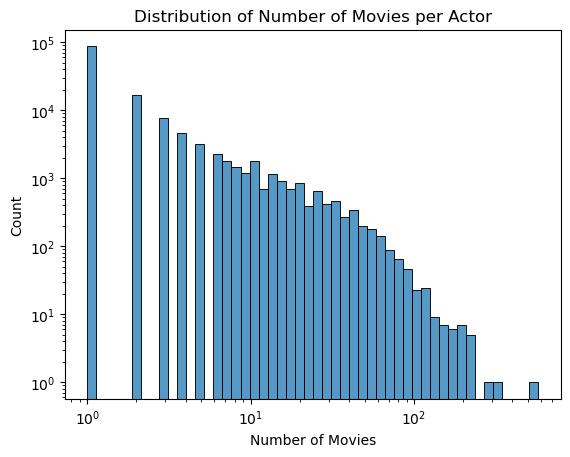

Number of actors that have played in only one movie: 87320
Number of actors that have played in less than 10 movies: 126320


In [66]:
actors_load['numMovies'] = actors_load['fbID'].apply(lambda x: len(x))

sns.histplot(data=actors_load, x='numMovies', bins=50, log_scale=(True, True))
plt.title("Distribution of Number of Movies per Actor")
plt.xlabel("Number of Movies")
plt.ylabel("Count")
plt.show()

num_actors_one_movie = (actors_load['numMovies'] == 1).sum()
print(f"Number of actors that have played in only one movie: {num_actors_one_movie}")
num_actors_ten_movies = (actors_load['numMovies'] < 10).sum()
print(f"Number of actors that have played in less than 10 movies: {num_actors_ten_movies}")

#TODO Choose number of minimum number of movies played by actors 
# Do we all agree with 10, because we are technically removing a LOT of actors?

We observe that a significant proportion of actors have contributed to fewer than 10 movies. For the purpose of our analysis, we have chosen to exclude these actors from consideration to focus on individuals with more extensive careers. 

The distribution of the number of movies per actor now is:

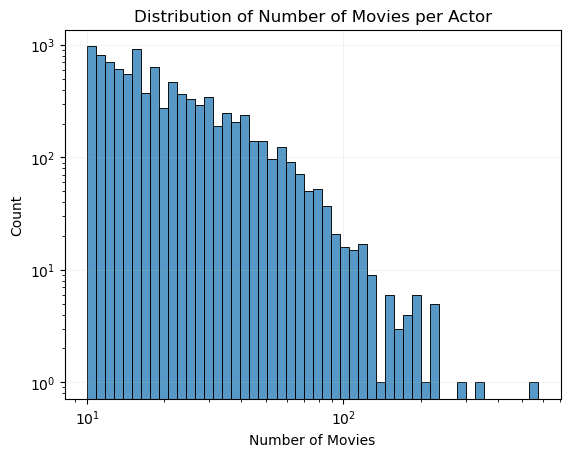

In [67]:
actors_load = actors_load[actors_load['numMovies'] >= 10]  # Pour ta partie ça fait pas sens de faire ça
sns.histplot(data=actors_load, x='numMovies', bins=50, log_scale=(True, True))
plt.title("Distribution of Number of Movies per Actor")
plt.xlabel("Number of Movies")
plt.ylabel("Count")
plt.grid(alpha=0.15)
plt.show()

Let us now look at the year of birth of the actors considered.

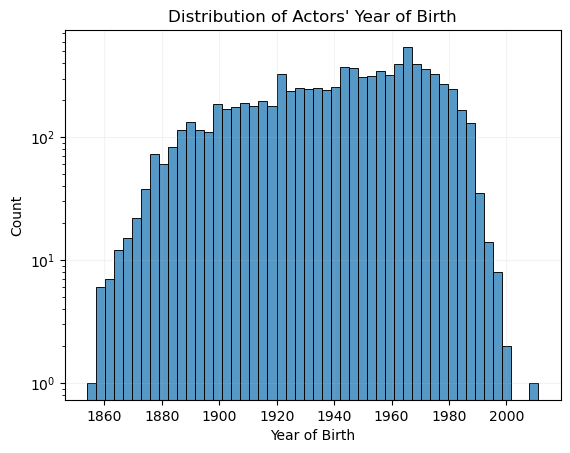

The minimum year of birth is 1854.0 and the maximum year of birth is 2011.0.


In [68]:
actors_load['actorDOB'] = pd.to_datetime(actors_load['actorDOB'], errors="coerce")  # TODO au début
actors_load['yearOfBirth'] = actors_load['actorDOB'].dt.year  #TODO au début

# Plot histogram
sns.histplot(data=actors_load, x='yearOfBirth', bins=50, log_scale=(False, True))
plt.title("Distribution of Actors' Year of Birth")
plt.xlabel("Year of Birth")
plt.ylabel("Count")
plt.grid(alpha=0.15)
plt.show()

min_year = actors_load['yearOfBirth'].min()
max_year = actors_load['yearOfBirth'].max()

print(f"The minimum year of birth is {min_year} and the maximum year of birth is {max_year}.")


From 1854 to 1970, there appears to be a noticeable increase in the number of actors born during this period. This rise could be indicative of several factors, such as the increasing popularity of movies as a form of entertainment, the growth of the film industry, and the increasing recognition of acting as a viable and esteemed profession. A decrease in the number of actors can be noticed after 1975, which can be explained by the fact that some 'future' actors may have not started their career yet.

Let us now see if there is a difference in this distribution depending on the gender.

Number of female actors: 3183
Number of male actors: 6237
Percentage of female actors: 33.789808917197455


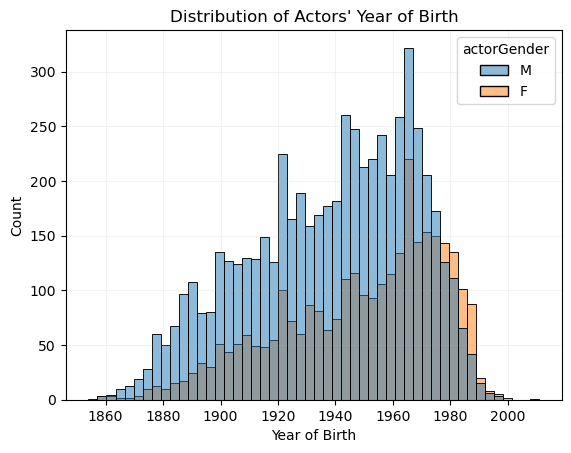

In [69]:
num_female_actors = actors_load['actorGender'].value_counts()['F']
num_male_actors = actors_load['actorGender'].value_counts()['M']

print("Number of female actors:", num_female_actors)
print("Number of male actors:", num_male_actors)
print("Percentage of female actors:", 100 * num_female_actors / (num_female_actors + num_male_actors))

# Plot histogram
sns.histplot(data=actors_load, x='yearOfBirth', bins=50, hue='actorGender')
plt.title("Distribution of Actors' Year of Birth")
plt.xlabel("Year of Birth")
plt.ylabel("Count")
plt.grid(alpha=0.15)
plt.show()

Number of female actors: 3183
Number of male actors: 6237
Percentage of female actors: 33.79%


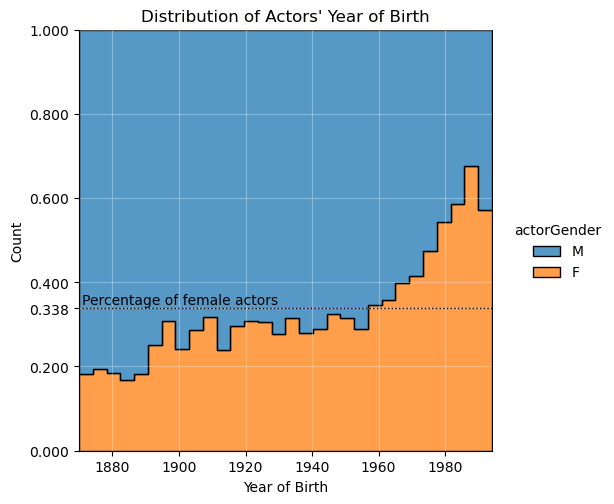

In [70]:
# ADDED by valérie, c'est un peu plus beau que le plot d'après mais je sais pas
num_female_actors = actors_load["actorGender"].value_counts()["F"]
num_male_actors = actors_load["actorGender"].value_counts()["M"]
proportion_male_female = num_female_actors / (num_female_actors + num_male_actors)

print("Number of female actors:", num_female_actors)
print("Number of male actors:", num_male_actors)
print(f"Percentage of female actors: {proportion_male_female:.2%}")
data = actors_load[
    (actors_load["yearOfBirth"] >= 1870) & (actors_load["yearOfBirth"] <= 1995)
    ]  # TODO PK çA ??
sns.displot(
    data,
    x="yearOfBirth",
    hue="actorGender",
    kind="hist",
    multiple="fill",
    element="step",
)
plt.hlines(proportion_male_female, 1871, 1994, colors="black", linestyles="dotted", linewidth=1)
plt.text(1871, proportion_male_female + 0.01, "Percentage of female actors")
plt.title("Distribution of Actors' Year of Birth")
plt.xlabel("Year of Birth")
plt.ylabel("Count")
plt.yticks(list(plt.yticks()[0]) + [proportion_male_female])
plt.grid(alpha=0.3, color="white")
plt.show()

There is a larger number of male actors than female actors. However, it seems that the proportion of female actors is increasing with time. 

Excluding the tails, specifically the lower and upper 10% of the interval, we can visualize the evolution of female actors, which is indeed increasing. This exclusion can be justified by the consideration that some actors may not have yet started their careers, particularly those entering the industry after 1990. By focusing on the central portion of the data, we aim to provide a more accurate depiction of the evolving gender composition among actors over the relevant time frame.

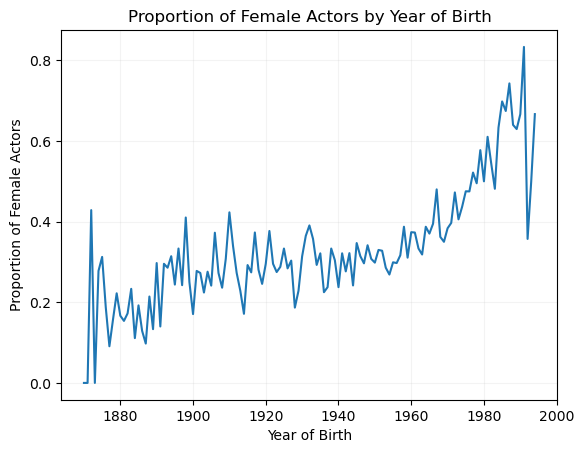

In [71]:
# group actors by year of birth and calculate proportion of female actors
prop_female_actors = (
    actors_load[
        (actors_load["yearOfBirth"] >= 1870) & (actors_load["yearOfBirth"] <= 1995)
        ]
    .groupby("yearOfBirth")["actorGender"]
    .apply(lambda x: (x == "F").sum() / len(x))
)

# plot the proportion of female actors per year of birth
plt.plot(prop_female_actors.index, prop_female_actors.values)
plt.xlabel("Year of Birth")
plt.ylabel("Proportion of Female Actors")
plt.title("Proportion of Female Actors by Year of Birth")
plt.grid(alpha=0.15)
plt.show()

We now want to analyze the career start ages of actors. This will be determined by calculating the age at which an actor first appears in a movie within our dataset. To ensure an accurate assessment of career beginnings and to avoid erroneously identifying a mid-career movie as the initial one due to a lack of data before it, we will consider actors born after the release year of the earliest movie included in our dataset.

In [72]:
print('Minimum release year for movies dataset: ', movies_load['releaseYear'].min())
actors_after_1888 = actors_load[actors_load['yearOfBirth'] > 1888]
print('Number of actors after 1888: ', actors_after_1888.shape[0])

Minimum release year for movies dataset:  1888.0
Number of actors after 1888:  8349


In [74]:
# Define a function to extract the minimum age from the ageAtMovieRelease dictionary
def get_min_age(x):
    if isinstance(x, dict):
        return min(x.values())
    else:
        return np.nan


# Apply the function to the ageAtMovieRelease column
actors_after_1888['ageAtFirstMovie'] = actors_after_1888['ageAtMovieRelease'].apply(get_min_age)

The mean age at first movie appearance is 25.26 years old.
The median age at first movie appearance is 25.00 years old.
Minimum age at first movie appearance: -50.0
Maximum age at first movie appearance: 75.0


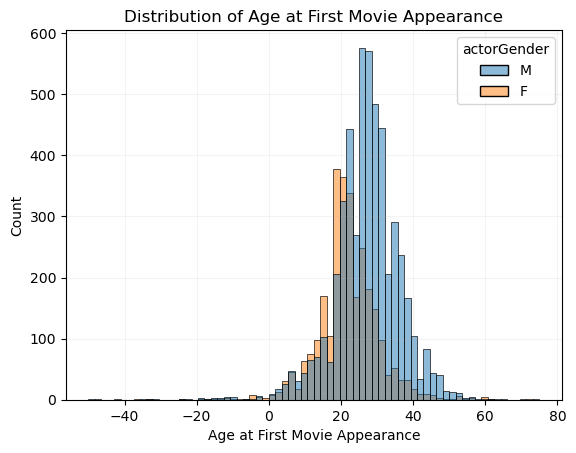

In [76]:
# Statistics on age at first movie appearance
mean_age = actors_after_1888['ageAtFirstMovie'].mean()
median_age = actors_after_1888['ageAtFirstMovie'].median()

print(f"The mean age at first movie appearance is {mean_age:.2f} years old.")
print(f"The median age at first movie appearance is {median_age:.2f} years old.")
print("Minimum age at first movie appearance:", actors_after_1888['ageAtFirstMovie'].min())
print("Maximum age at first movie appearance:", actors_after_1888['ageAtFirstMovie'].max())

# Plot histogram of age at first movie appearance
sns.histplot(data=actors_after_1888, x='ageAtFirstMovie', bins=70, hue='actorGender')
plt.title("Distribution of Age at First Movie Appearance")
plt.xlabel("Age at First Movie Appearance")
plt.ylabel("Count")
plt.grid(alpha=0.15)
plt.show()

Based on the observed distributions, it appears that there is a discrepancy in the age at which individuals of different genders make their first movie appearances, with male actors seemingly starting at an older age compared to female actors. To formally test this observation, we can conduct a t-test with the null hypothesis that the mean age at first movie for both genders is equal, which will help confirm whether the observed difference is statistically significant or could be due to random chance.

In [77]:
men_data = actors_after_1888.loc[actors_after_1888['actorGender'] == 'M', 'ageAtFirstMovie']
women_data = actors_after_1888.loc[actors_after_1888['actorGender'] == 'F', 'ageAtFirstMovie']

# Perform the t-test
t_stat, p_value = ttest_ind(men_data.dropna(), women_data.dropna(), equal_var=False, alternative='greater')

# Print the results
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.2f}")


t-statistic: 26.02
p-value: 0.00


Given the p-value of 0.00, it is extremely unlikely to observe such a large difference in age at first movie appearance between men and women if there were no true difference in the population. Therefore, we may reject the null hypothesis. It can thus be suggested that the age at which male actors make their first movie appearance is statistically significantly greater than that of female actors.

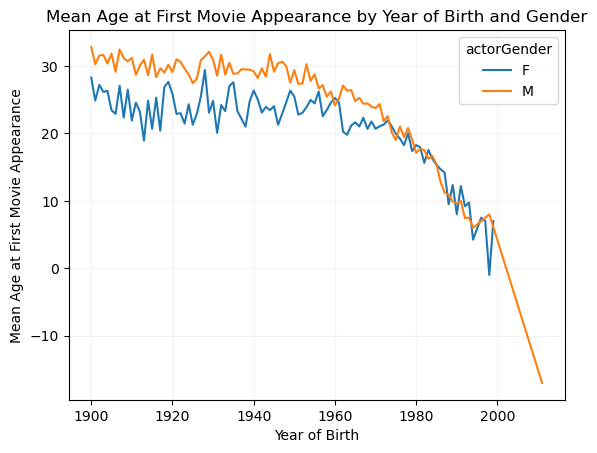

In [78]:
# Group actors by year of birth and gender and calculate mean age at first movie appearance
mean_age_by_year_gender = actors_after_1888.groupby(['yearOfBirth', 'actorGender'])[
    'ageAtFirstMovie'].mean().reset_index()

# Plot mean age at first movie appearance per year of birth and gender
sns.lineplot(data=mean_age_by_year_gender, x='yearOfBirth', y='ageAtFirstMovie', hue='actorGender')
plt.title('Mean Age at First Movie Appearance by Year of Birth and Gender')
plt.xlabel('Year of Birth')
plt.ylabel('Mean Age at First Movie Appearance')
plt.grid(alpha=0.15)

#TODO We really have to solve this problem of age 
#TODO Once this is solved, do analysis on this (can we say that there is no difference from a 
# certain year because gender equality and all)

In [79]:
print('Maximum release year for movies dataset: ', movies_load['releaseYear'].max())
actors_full_career = actors_after_1888[actors_after_1888['yearOfBirth'] < 2017 - 61]
#TODO: discuss with someone about this choice
print('Number of actors between 1888 and 1967: ', actors_full_career.shape[0])

Maximum release year for movies dataset:  2016.0
Number of actors between 1888 and 1967:  4913


In [80]:
# Define a function to extract the maximum age from the ageAtMovieRelease dictionary
def get_max_age(x):
    if isinstance(x, dict):
        return max(x.values())
    else:
        return np.nan


# Apply the function to the ageAtMovieRelease column
actors_full_career['ageAtLastMovie'] = actors_full_career['ageAtMovieRelease'].apply(get_max_age)
# Calculate career length
actors_full_career['careerLength'] = actors_full_career['ageAtLastMovie'] - actors_full_career['ageAtFirstMovie']

To choose the upper limit for the birth years of actors, we conducted an analysis of the age at the last movie appearance within a specified interval that should be immune to the influence of cutting points (taking into account a 100-year margin). The results revealed an average age of approximately 60.96 years, which thus taken off from 2017, last movie release year in our dataset.

Mean age at last movie appearance: 60.89
Median age at last movie appearance: 62.00


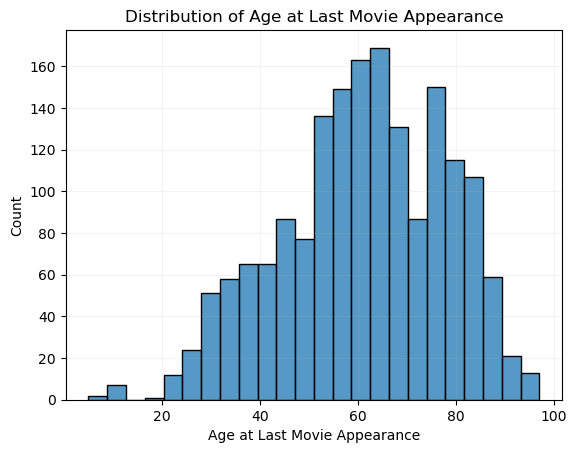

In [81]:
# Mean and median of age at last movie appearance
age_last_movie = actors_full_career[actors_full_career.yearOfBirth < 2017 - 90]['ageAtLastMovie']
print(f"Mean age at last movie appearance: {age_last_movie.mean():.2f}")
print(f"Median age at last movie appearance: {age_last_movie.median():.2f}")

# Plot histogram of age at last movie appearance
sns.histplot(data=actors_full_career[actors_full_career.yearOfBirth < 2017 - 90], x='ageAtLastMovie')
plt.title('Distribution of Age at Last Movie Appearance')
plt.xlabel('Age at Last Movie Appearance')
plt.ylabel('Count')
plt.grid(alpha=0.15)
plt.show()

The mean career length is 32.72 years.
The median career length is 32.00 years.


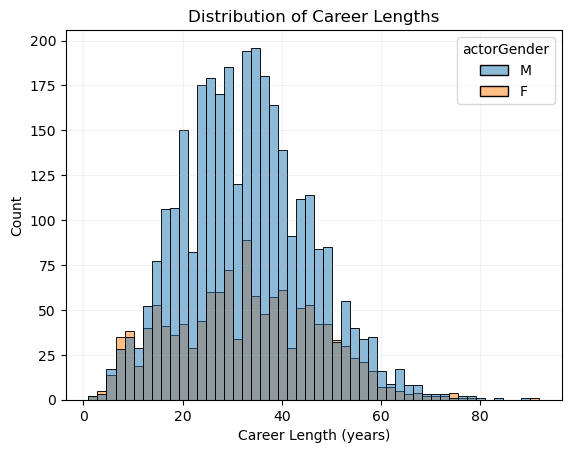

In [82]:
mean_career_length = actors_full_career['careerLength'].mean()
median_career_length = actors_full_career['careerLength'].median()

print(f"The mean career length is {mean_career_length:.2f} years.")
print(f"The median career length is {median_career_length:.2f} years.")

sns.histplot(data=actors_full_career, x='careerLength', bins=50, hue='actorGender')
plt.title("Distribution of Career Lengths")
plt.xlabel("Career Length (years)")
plt.ylabel("Count")
plt.grid(alpha=0.15)
plt.show()

A t-test was conducted to assess whether there is a statistically significant difference in the career lengths between male and female actors.

In [83]:
# extract career lengths for male and female actors
male_career_lengths = actors_full_career[actors_full_career['actorGender'] == 'M']['careerLength']
female_career_lengths = actors_full_career[actors_full_career['actorGender'] == 'F']['careerLength']

# perform the t-test
t_stat, p_value = ttest_ind(male_career_lengths.dropna(), female_career_lengths.dropna(), equal_var=False)

# print the results
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.2f}")


t-statistic: 0.36
p-value: 0.72


The t-statistic of 0.41 suggests a relatively small difference in means between the two groups. The p-value of 0.68 is above the significance threshold 0.05, indicating that there is insufficient evidence to reject the null hypothesis. In other words, the observed difference in the meands of career lengths between male and female actors is not statistically significant.

#TODO: same means but distribution looks different, that's weird

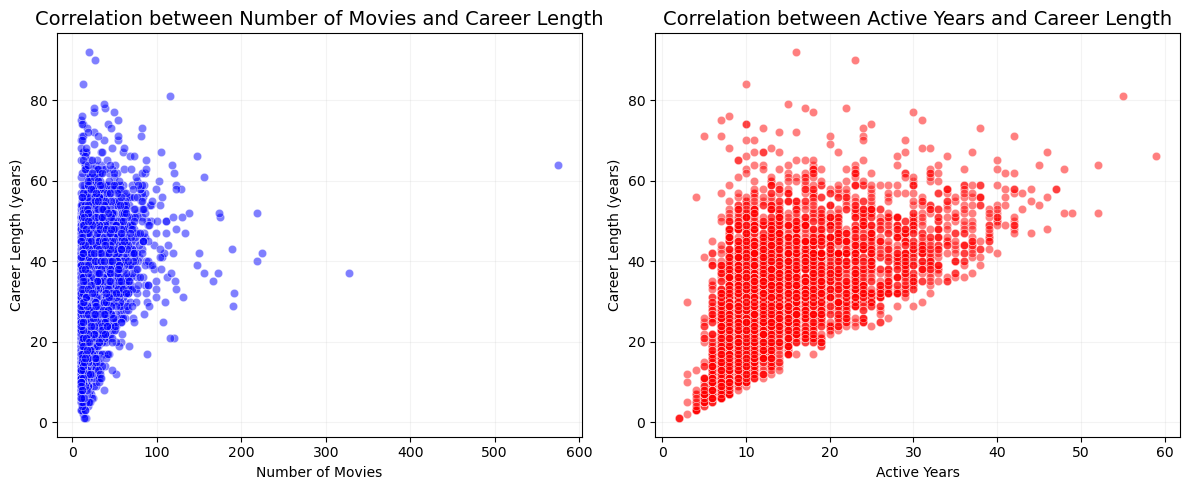

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(data=actors_full_career, x='numMovies', y='careerLength', ax=ax1, color='blue', alpha=0.5)
ax1.set_title("Correlation between Number of Movies and Career Length", fontsize=14)
ax1.set_xlabel("Number of Movies")
ax1.set_ylabel("Career Length (years)")
ax1.grid(alpha=0.15)

# Extract unique age values from ageAtMovieRelease dictionary
#TODO: Explain what is active years
actors_full_career['activeYears'] = actors_full_career['ageAtMovieRelease'].apply(
    lambda x: len(set(x.values())) if isinstance(x, dict) else np.nan)

sns.scatterplot(data=actors_full_career, x='activeYears', y='careerLength', ax=ax2, color='red', alpha=0.5)
ax2.set_title("Correlation between Active Years and Career Length", fontsize=14)
ax2.set_xlabel("Active Years")
ax2.set_ylabel("Career Length (years)")
ax2.grid(alpha=0.15)

plt.tight_layout()
plt.show()

#TODO: Interpretation de ces plots

In [85]:
# Calculate average number of movies per year
actors_full_career['avgMoviesPerYear'] = actors_full_career['numMovies'] / actors_full_career['careerLength']

# Calculate active years per career length
actors_full_career['activeYearsPerCareerLength'] = actors_full_career['activeYears'] / actors_full_career[
    'careerLength']

#TODO: Do something out of this (potentially)

## NOM DE LA QUESTION SUR LES GENRES #TODO

In [103]:
actors = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID": parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_list,
        "countries": parse_list,
        "genresCmu": parse_list,
        "genresImdb": parse_list
    },
)

## Cleaning `genres`

The `genresCmu` column, while having very few missing values, exhibits a wide diversity of genres, as outlined in the cell below. Additionally, the genres are not standardized; for instance, we observe distinctions like 'Action', 'Adventure' and 'Action/Adventure' making it challenging to analyze. As for `genresImdb`, we have a reasonably manageable number of unique genres. However, due to the merge, we notice a considerable number of missing values compared to `genresCmu`.

In [105]:
#TODO remove this?
# Updating the 'genresCmu' and 'genresImdb' columns to get a list of genres without the IDs for each movie
#movies['genresCmu'] = movies['genresCmu'].apply(parse_list)
#movies['genresImdb'] = movies['genresImdb'].apply(parse_list)
#lambda x: x.split(',') if not (isinstance(x, float) or x == "\\N") else np.nan)

In [106]:
percent_missing = movies.isnull().sum() * 100 / len(movies)
print(
    f"Proportion of missing values in each column:\n{percent_missing[['genresCmu', 'genresImdb']]}"
)

number_genres_cmu = len(movies.genresCmu.explode().unique())
number_genres_imdb = len(movies.genresImdb.explode().unique())
print("\nNumber of unique genres in\n" +
      "CMU:", number_genres_cmu, "\n"
                                 "Imdb:", number_genres_imdb)

Proportion of missing values in each column:
genresCmu      2.801803
genresImdb    39.524171
dtype: float64

Number of unique genres in
CMU: 364 
Imdb: 28


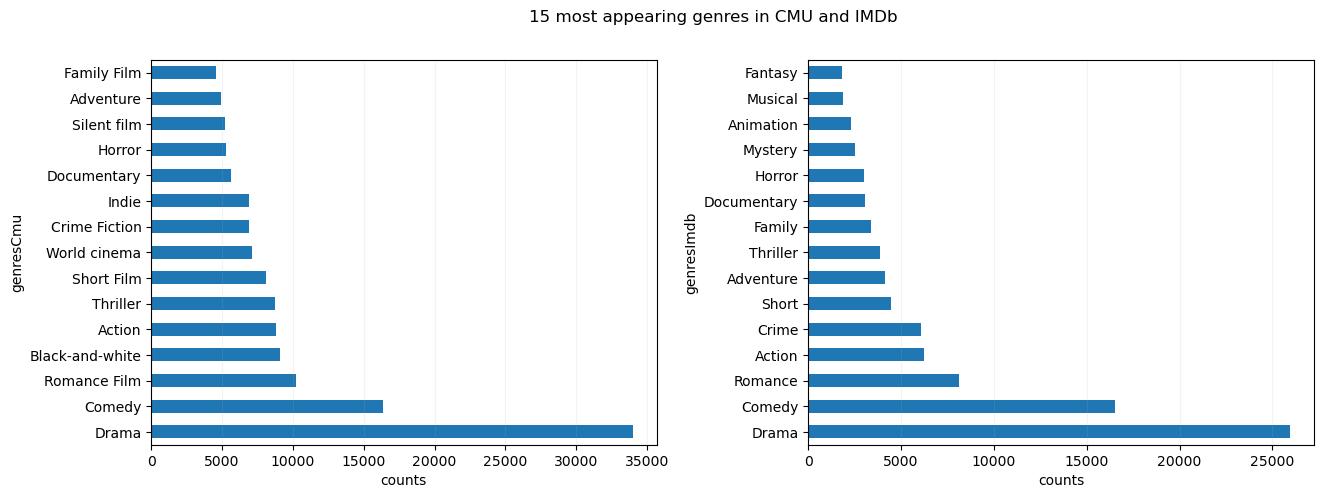

In [107]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle("15 most appearing genres in CMU and IMDb")

fig.add_subplot(121)
occurences_cmu = movies["genresCmu"].explode().value_counts()
occurences_cmu[:15].plot(kind='barh')
plt.grid(alpha=0.15, axis="x")
plt.xlabel("counts")

fig.add_subplot(122)
occurences_imdb = movies["genresImdb"].explode().value_counts()
occurences_imdb[:15].plot(kind='barh')
plt.grid(alpha=0.15, axis="x")
plt.xlabel("counts")
plt.subplots_adjust(wspace=0.3)

To address the issue of numerous missing values in 'Imdb' and the diversity of genres in 'CMU', we will first combine the genres for each movie.

In [108]:
combinedGenres = movies["genresImdb"].apply(
    lambda x: list(x) if isinstance(x, list) else []
) + movies["genresCmu"].apply(lambda x: list(x) if isinstance(x, list) else [])

combinedGenres = combinedGenres.apply(lambda x: set(x) if len(x) > 0 else np.nan)

movies["combinedGenres"] = combinedGenres
movies["combinedGenres"]

0         {Biographical film, Crime Drama, Mystery, Drama}
1                            {Crime, Crime Fiction, Drama}
2        {Horror, Thriller, Mystery, Erotic thriller, P...
3                                                  {Drama}
4        {Short, Silent film, Black-and-white, Indie, C...
                               ...                        
81621                                              {Drama}
81622    {Biographical film, Biography, Drama, Document...
81623                                     {Satire, Comedy}
81624    {Japanese Movies, Animation, Science Fiction, ...
81625                    {Teen, Thriller, Slasher, Horror}
Name: combinedGenres, Length: 81626, dtype: object

Once we have a set of unique genres for each movie, the idea is to create a long string by concatenating all the genres for all the movies.

In [109]:
genres = movies.dropna(subset="combinedGenres").explode(column="combinedGenres").combinedGenres.values
genres_str = " ".join(str(g) for g in genres)

genres_unique = np.unique(genres)

Then we want to split this long string using the `split_characters` found by the code. This will, for example, allow us to split the genre 'Action/Adventure' into 'Adventure' and 'Action'. The list `words` contains all the words appearing throughout all the combinedGenres. The more a word appears in the list `words`, the more it appears in combinedGenres.

In [110]:
split_characters = set()
for letter in genres_str:
    if (
            not letter.isalpha() and letter != " "
    ):  # letter.isalpha() return True if the letter is an alphabetic string
        split_characters.add(letter)

print(split_characters)

string = genres_str
for delimiter in split_characters:
    string = " ".join(string.split(delimiter))

words = string.split(" ")
print("\nThe first 15 terms of the list words", words[:15])

{'&', "'", '5', '-', '9', ']', '/', '['}

The first 15 terms of the list words ['Biographical', 'film', 'Crime', 'Drama', 'Mystery', 'Drama', 'Crime', 'Crime', 'Fiction', 'Drama', 'Horror', 'Thriller', 'Mystery', 'Erotic', 'thriller']


Now, our objective is to identify the most frequently occurring words in our list of `words`. As one can observe above, some words are presented in uppercase, while others are in lowercase. To ensure consistency, we convert all text to lowercase and proceed to identify words that appear more than 2000 times. 

In [111]:
words = list(map(lambda x: x.lower(), words))

counts = pd.Series(words).value_counts()
new_genres_serie = pd.Series(counts[counts > 2000])
new_genres_serie.index

Index(['drama', 'film', 'comedy', 'romance', 'action', 'crime', 'thriller',
       'short', 'adventure', 'fiction', 'family', 'black', 'and', 'white',
       'cinema', 'world', 'indie', 'horror', 'romantic', 'documentary',
       'silent', 'musical', 'fantasy', 'mystery', 'movies', 'animation', 'war',
       '', 'science', 'western', 'movie', 'biography', 'japanese', 'music',
       'history'],
      dtype='object')

Finally, we have a list of words representing our new genres. After filtering out words that do not correspond to actual genres, we create a dictionary, `genres_dict`, linking genres from 'CMU' and 'IMDb' to our new list of genres. For example, all genres containing the word 'drama' will be associated with the genre 'Drama.' 

A list of genres associated with 'Drama' is displayed two cells below.

In [112]:
# Dropping irrelevant genres and characters from the series
new_genres_serie = new_genres_serie.drop(
    index=[
        "",
        "film",
        "cinema",
        "movie",
        "movies",
        "black",
        "and",
        "white",  # combining "black-and-white" instead of having separate entries
    ]
)

# Adding "black-and-white" to the indices
new_genres_serie["black-and-white"] = 0

# Capitalizing the new genres and create a list from the indices
new_genres = list(map(lambda x: x.capitalize(), new_genres_serie.index))

genres_dict = {genre: set() for genre in new_genres}
for new_genre in new_genres:
    for genre in genres_unique:
        if new_genre.lower() in genre.lower():
            genres_dict[new_genre].add(genre)

# Merging "Romantic" into "Romance" since can be considered equivalent
genres_dict["Romance"] = genres_dict["Romance"].union(genres_dict.pop("Romantic"))
new_genres.remove("Romantic")

# Merging "Music" into "Musical" since can be considered equivalent
genres_dict["Musical"] = genres_dict["Music"].union(genres_dict.pop("Music"))
new_genres.remove("Music")

print(len(new_genres), "unified genres listed below")
new_genres

26 unified genres listed below


['Drama',
 'Comedy',
 'Romance',
 'Action',
 'Crime',
 'Thriller',
 'Short',
 'Adventure',
 'Fiction',
 'Family',
 'World',
 'Indie',
 'Horror',
 'Documentary',
 'Silent',
 'Musical',
 'Fantasy',
 'Mystery',
 'Animation',
 'War',
 'Science',
 'Western',
 'Biography',
 'Japanese',
 'History',
 'Black-and-white']

In [113]:
genres_dict["Drama"]

{'Addiction Drama',
 'Childhood Drama',
 'Comedy-drama',
 'Costume drama',
 'Courtroom Drama',
 'Crime Drama',
 'Docudrama',
 'Drama',
 'Erotic Drama',
 'Family Drama',
 'Fantasy Drama',
 'Historical drama',
 'Inspirational Drama',
 'Legal drama',
 'Marriage Drama',
 'Melodrama',
 'Musical Drama',
 'Political drama',
 'Romantic drama'}

In conclusion to the cleaning process, we apply the function `unify_genres()` to our column combinedGenres, creating the new unique column genres. This transformation ensures that the genres are now meaningful for our analysis

In [114]:
def unify_genres(x):
    try:
        unified_genres = set()
        for genre in x:
            themes_in_genres = {t for t in new_genres if genre in genres_dict[t]}
            unified_genres = unified_genres.union(themes_in_genres)
        return unified_genres if unified_genres else np.nan

    except TypeError:
        return x


movies["genres"] = movies["combinedGenres"].apply(unify_genres)
# movies.drop(columns=["genresCmu","genresImdb","combinedGenres"],inplace=True) #TODO uncomment

## Genre Distribution in Our Dataset

Prior to investigating how actors evolve across various genres, let's first examine the distribution of genres within our dataset. We begin by looking at the occurrence of genres after the cleaning process.

Proportion of missing values in column genres 3.16%


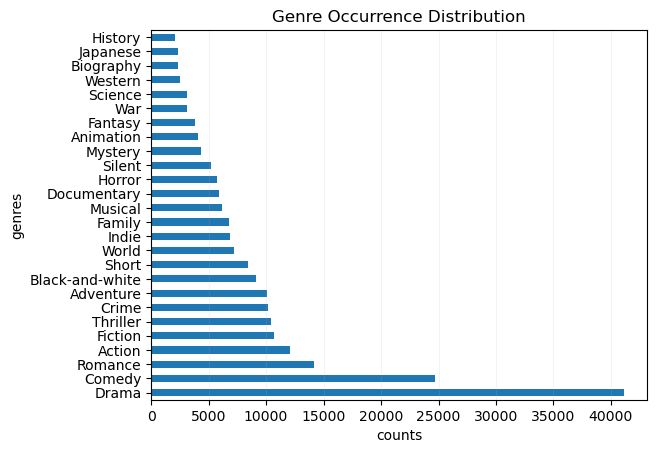

In [115]:
occurences = movies["genres"].explode().value_counts()
occurences.plot(kind="barh")
plt.title("Genre Occurrence Distribution")
plt.grid(alpha=0.15, axis="x")
plt.xlabel("counts")

percent_missing = movies["genres"].isnull().sum() / len(movies)
print(f"Proportion of missing values in column genres {percent_missing:.2%}")

Let's also examine the evolution of genres popularity over the years.

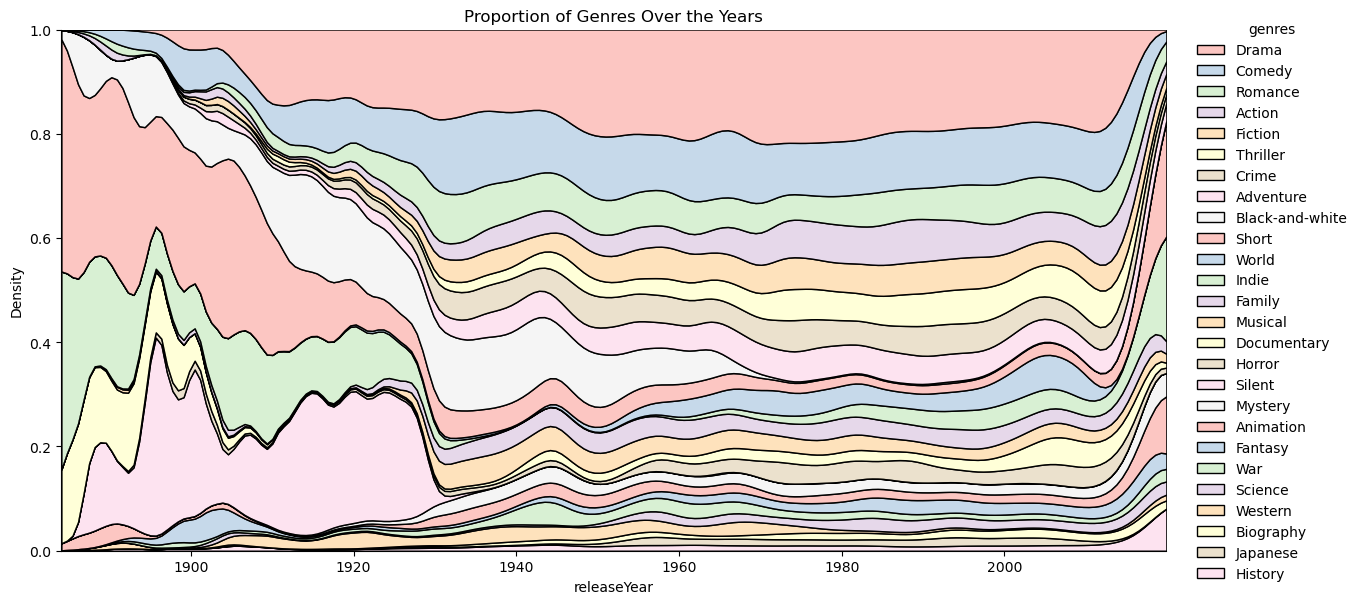

In [116]:
# Extracting relevant columns and exploding the 'genres' column for analysis
data = movies[["releaseYear", "genres"]].explode("genres").reset_index()

# Generating a color palette for distinct genres
palette = sns.color_palette("Pastel1", n_colors=len(data["genres"].unique()))

# Creating a kernel density estimate (kde) plot to visualize genre distribution over release years
sns.displot(
    data,
    x="releaseYear",
    hue="genres",
    kind="kde",
    multiple="fill",
    bw_adjust=0.5,
    hue_order=movies.genres.explode().dropna().value_counts().index.tolist(),
    palette=palette,
    aspect=2,
    height=6,
)
plt.title("Proportion of Genres Over the Years")
plt.show()

This visualization effectively captures the decline of silent movies (pale rose) around 1930 and the diminishing presence of black-and-white films (light gray) in the 70s. Regarding other genres, it appears that certain genres enjoyed greater popularity during specific epochs. A notable example is the Western genre, which seems to have been more popular before the 1980s. However, it's crucial to approach this plot with caution, considering that the number of movies in our dataset is not evenly distributed across the years. This imbalance is evident in the figure below.

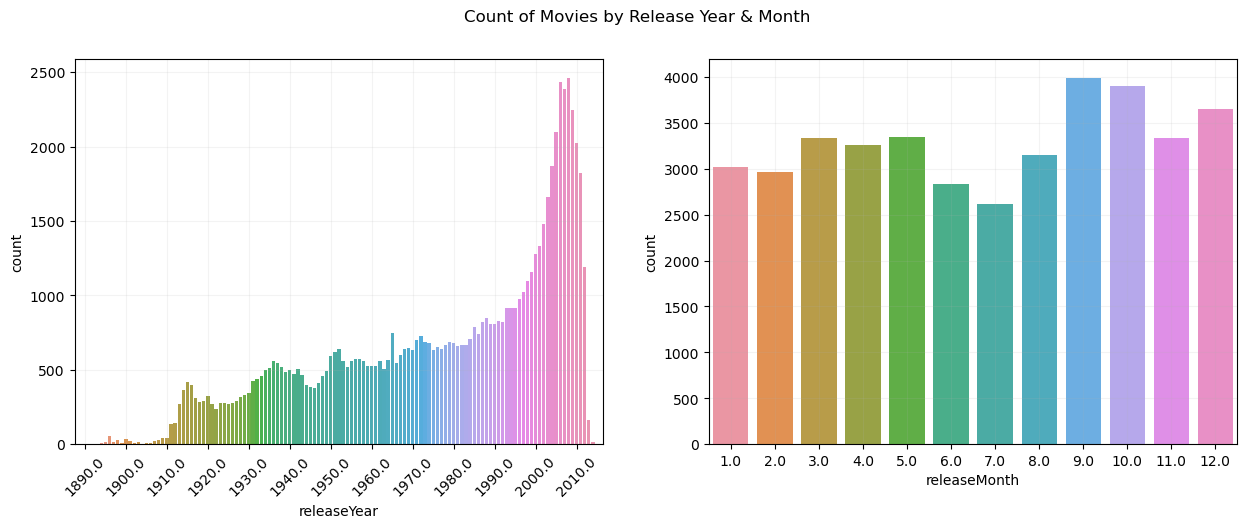

In [117]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle('Count of Movies by Release Year & Month')

# Subplot 1: Movie count by release year
fig.add_subplot(121)
sns.countplot(x='releaseYear', data=movies)
plt.xticks(plt.xticks()[0][2::10], rotation=45)
plt.grid(alpha=0.15)

# Subplot 2: Movie count by release month
fig.add_subplot(122)
sns.countplot(x="releaseMonth", data=movies)
plt.grid(alpha=0.15)

plt.subplots_adjust(wspace=0.2)  # Adjusting subplot spacing
plt.show()

Analyzing movie genres poses a challenge because films often belong to multiple genres as one can observe bellow.

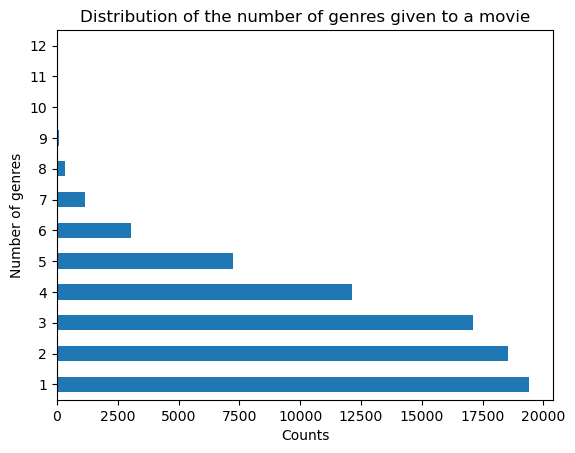

In [118]:
movies["genres"].dropna().apply(lambda x: len(x)).value_counts().plot(kind="barh")
plt.title("Distribution of the number of genres given to a movie")
plt.ylabel("Number of genres");
plt.xlabel("Counts");

To gain a deeper insight into this phenomenon within our dataset and identify the most overlapping genres, we generate a heatmap as shown in the figure below. Each row in the genre heatmap displays the probability of being associated with another genre, indicated by the corresponding column. The diagonal represents the probability of a genre appearing on its own.

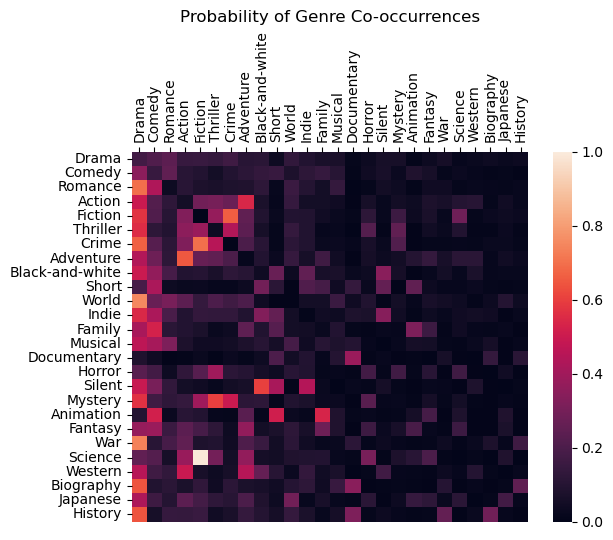

In [119]:
# Explode the genres and get dummies
genre_dummies = pd.get_dummies(movies["genres"].explode())
genre_dummies.index.name = "index"
genre_dummies_grouped = genre_dummies.groupby("index").sum()

# Get ordered list of genres
genres_list = movies["genres"].explode().dropna().value_counts().index.to_list()

# Calculate co-occurrences
co_occurrences_matrix = np.zeros((len(genres_list), len(genres_list)))
for x, genre_x in enumerate(genres_list):
    for y, genre_y in enumerate(genres_list):
        if genre_x == genre_y:
            co_occurrences_matrix[x, y] = (
                    movies["genres"].apply(lambda x: x == {genre_x}).sum()
                    / genre_dummies_grouped[genre_x].sum()
            )
        else:
            co_occurrences_matrix[x, y] = (
                                                  (genre_dummies_grouped[genre_x] + genre_dummies_grouped[genre_y]) == 2
                                          ).sum() / genre_dummies_grouped[genre_x].sum()

# Plot heatmap
heatmap_ax = sns.heatmap(
    co_occurrences_matrix,
    xticklabels=genres_list,
    yticklabels=genres_list,
    vmax=1,
    vmin=0,
)

# Move x-axis to top and rotate labels
heatmap_ax.xaxis.tick_top()
plt.xticks(rotation=90)

# Set title
plt.title("Probability of Genre Co-occurrences");

It's not surprising to observe that the genre "Science" is consistently associated with "Fiction" in our dataset, given that Science Fiction movies are inherently a combination of both elements. However, the relationship is not reciprocal for "Fiction," which exhibits a higher probability of being paired with "Crime" than with "Science." Additionally, genres rarely stand alone, with the exception of "Documentary," which appears independently about 50% of the time. Another noteworthy observation is that genres appearing in the same years tend to have a higher probability of co-occurrence, as seen in the case of 'Silent' and 'Black-and-White.'

This plot is crucial for our analysis as it provides insights into the relationships between genres, helping us understand trends influenced by these overlaps.

## Actors and Genres

First, let's examine the gender distribution within each genre, keeping in mind that the average proportion of women in our dataset is 34%.

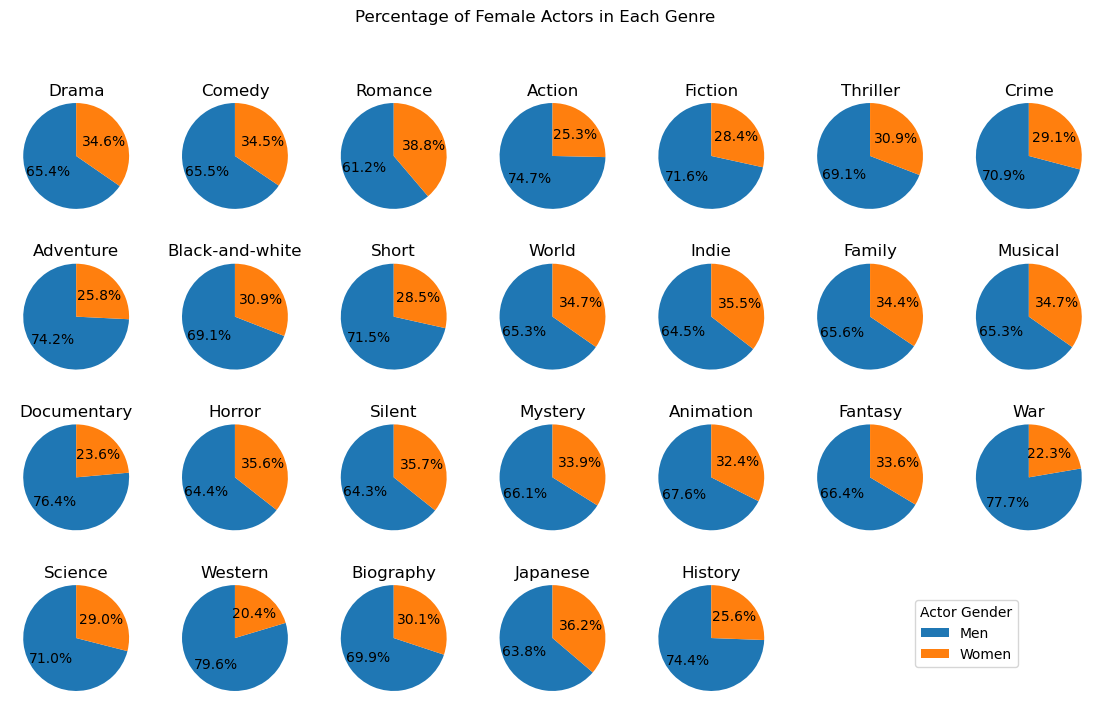

In [120]:
actors["numMovies"] = actors["fbID"].apply(
    lambda x: len(x)
)  # TODO: Remove this line in the initial cleanup

# Exploding actors dataset on movies and merging with movie genres
actors_exploded = explode_on_movies(actors)
merged_actors_genres = actors_exploded.merge(
    movies[["fbID", "genres"]], how="left", on="fbID"
)

# Exploding the merged dataset on genres
exploded_actors_genres = merged_actors_genres.explode("genres")

# Pie charts for each genre
fig, axes = plt.subplots(4, 7, figsize=(14, 8))
for genre, ax in zip(genres_list, axes.ravel()):
    genders = exploded_actors_genres[exploded_actors_genres["genres"] == genre][
        "actorGender"
    ].value_counts()
    patches, _, _ = ax.pie(genders, startangle=90, autopct="%1.1f%%")
    ax.set_title(genre, y=0.9)

# Removing unnecessary subplots
axes[3, 5].axis("off")
axes[3, 6].axis("off")

# Setting overall title and legend
fig.suptitle("Percentage of Female Actors in Each Genre")
fig.legend(
    patches, labels=["Men", "Women"], title="Actor Gender", bbox_to_anchor=(0.85, 0.25)
)

The proportion of female actors varies significantly across different genres. The highest proportion is found in Romance, while the lowest is observed in Western films.

In the following cell, our objective is to analyze whether an actor's roles percentage in a particular genre correlates with the proportion of movies they have played in another genre. To achieve this, we begin by regrouping all the movies associated with each actor and recording the genre count for each. This count is then normalized by dividing it by the total number of movies played. As a result, for each actor, we obtain a vector representing the frequency of unique genres, as illustrated above.

In [121]:
# Creating dummy variables for genres and counting occurrences for each actor and movie
genre_dummies = pd.get_dummies(
    exploded_actors_genres[["fbActorID", "numMovies", "genres"]],
    columns=["genres"],
    prefix="",
    prefix_sep="",
)

# Grouping by actor and summing genre counts
actor_genre_counts = (
    (1 * genre_dummies)
    .groupby("fbActorID")
    .agg({"numMovies": lambda x: x.mean(), **dict.fromkeys(genres_list, sum)})
)

# Filtering actors with at least 50 movies to get meaningfull genres proportions
actor_genre_counts = actor_genre_counts.query("numMovies >= 50")

# Calculating genre proportions for each actor
actor_genre_proportion = actor_genre_counts[genres_list].div(
    actor_genre_counts["numMovies"], axis=0
)

print("Number of actors kept to evaluate correlation:", len(actor_genre_proportion))

actor_genre_proportion

Number of actors kept to evaluate correlation: 654


,Drama,Comedy,Romance,Action,Fiction,Thriller,Crime,Adventure,Black-and-white,Short,...,Silent,Mystery,Animation,Fantasy,War,Science,Western,Biography,Japanese,History
fbActorID,,,,,,,,,,,,,,,,,,,,,
/m/010xjr,0.807692,0.134615,0.230769,0.423077,0.230769,0.192308,0.230769,0.538462,0.000000,0.000000,...,0.000000,0.057692,0.038462,0.076923,0.192308,0.038462,0.153846,0.057692,0.000000,0.076923
/m/011_r9,0.714286,0.339286,0.500000,0.071429,0.125000,0.089286,0.142857,0.107143,0.535714,0.035714,...,0.214286,0.071429,0.000000,0.053571,0.017857,0.017857,0.035714,0.017857,0.000000,0.035714
/m/011xjd,0.365079,0.126984,0.142857,0.301587,0.206349,0.158730,0.190476,0.365079,0.380952,0.000000,...,0.015873,0.190476,0.000000,0.158730,0.047619,0.063492,0.285714,0.015873,0.000000,0.015873
/m/01200d,0.709302,0.325581,0.302326,0.197674,0.104651,0.023256,0.116279,0.186047,0.616279,0.069767,...,0.348837,0.023256,0.000000,0.023256,0.139535,0.023256,0.186047,0.023256,0.000000,0.034884
/m/012c6j,0.671875,0.640625,0.625000,0.031250,0.031250,0.046875,0.093750,0.093750,0.531250,0.031250,...,0.265625,0.015625,0.000000,0.031250,0.031250,0.000000,0.015625,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/m/0q9kd,0.438356,0.835616,0.328767,0.178082,0.273973,0.164384,0.315068,0.219178,0.000000,0.013699,...,0.000000,0.054795,0.054795,0.136986,0.013699,0.041096,0.013699,0.027397,0.013699,0.000000
/m/0tj9,0.756614,0.296296,0.349206,0.449735,0.116402,0.153439,0.164021,0.195767,0.000000,0.005291,...,0.000000,0.031746,0.000000,0.042328,0.015873,0.005291,0.005291,0.005291,0.000000,0.015873
/m/0ywqc,0.684685,0.306306,0.135135,0.288288,0.306306,0.405405,0.279279,0.243243,0.000000,0.009009,...,0.000000,0.153153,0.018018,0.054054,0.135135,0.099099,0.018018,0.063063,0.027027,0.054054


For every pair of columns (genres) in our dataframe, we assess the correlation between them. The outcomes are displayed above. If the p-value of the Pearson correlation coefficient exceeds 0.05, we cannot dismiss the null hypothesis that the columns are uncorrelated. As a result, the results are depicted in the heatmap below only when the p-value is less than 0.05.

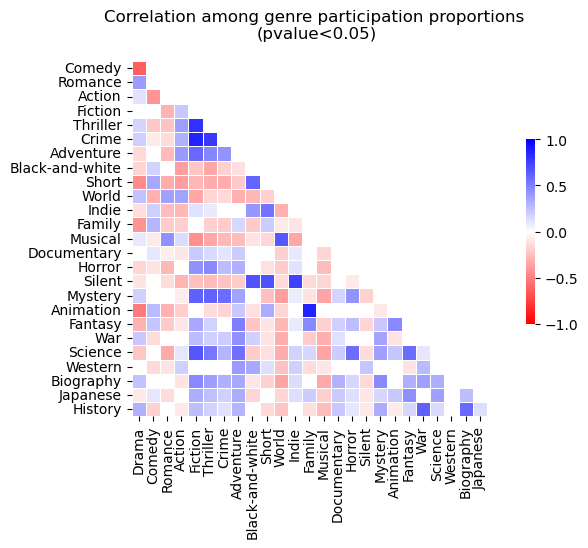

In [126]:
# Calculating Pearson correlation coefficients and p-values for genre proportions
pvalues = np.zeros((len(genres_list), len(genres_list)))
cor = np.zeros((len(genres_list), len(genres_list)))
for i, genre_i in enumerate(genres_list):
    for j, genre_j in enumerate(genres_list):
        cor[i, j], pvalues[i, j] = pearsonr(
            actor_genre_proportion[genre_i], actor_genre_proportion[genre_j]
        )

# Diverging color map for correlation visualization
divnorm = colors.CenteredNorm(vcenter=0, halfrange=np.max(np.abs(cor)))

# Mask for statistically insignificant correlations (p >= 0.05)
mask = np.triu(np.ones_like(cor, dtype=bool))
mask = mask + (pvalues >= 0.05) * 1

sns.heatmap(
    cor,
    yticklabels=genres_list,
    xticklabels=genres_list,
    cmap="bwr_r",
    norm=divnorm,
    square=True,
    mask=mask,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

plt.xticks(plt.xticks()[0][:-1])
plt.yticks(plt.yticks()[0][1:])
plt.title("Correlation among genre participation proportions \n(pvalue<0.05)");

The interpretation of the results should consider the earlier findings on movie co-occurrence. For instance, a high correlation between 'Crime' and 'Fiction' may stem from two possibilities:

1. Actors who appear in crime movies indeed have a higher likelihood of also participating in fiction.
2. All the crime movies featuring certain actors were simultaneously labeled as fiction, and vice versa.

In the second scenario, no definitive conclusion can be drawn about the correlation regarding the genre proportions of actors. However, in the case of a negative correlation, this could be attributed not only to movies lacking these shared genres but also to a nuanced influence on actors. Consider, for example, the genres of comedy and drama. While our co-occurrence matrix suggests a 30% probability of a comedy also being a drama, from an actor's perspective, playing roles in either genre seems to negatively influence the chances of participating in the other.

Moreover, regarding drama movies, although many genres show a high likelihood of association with drama based on the co-occurrence matrix, positive correlation is not always observed when viewed from an actor's standpoint.

To further explore the trajectory of actors across genres, we will constructing a Markov Chain in the following manner for milestone 3:

> Each state within the chain will symbolize a distinct genre, while the edges will indicate the probabilities of transitioning from one genre to another.

Our objective is to see the typical types of movies actors tend to embrace after participating in a specific genre. This exploration will provide insights into whether certain actors tend to remain within in a given genre or explore diverse genres. Moreover, we aim to investigate whether such tendencies vary depending on the age of the actors. To achieve this, we will develop two Markov chains - one for young actors and another for older ones - and analyze the potential differences in their genre-transition tendencies.

## Saving Preprocessed Datasets

### Removing Unnecessary Columns

We are excluding columns containing information irrelevant to our analysis from all datasets to optimize memory usage and enhance readability.

In [ ]:
# TODO enlever toutes les columns qu'on utilise pas dans TOUS les datasets

In [ ]:
movies.to_csv(DATA_FOLDER + "movies.csv", index=False)
actors.to_csv(DATA_FOLDER + "actors.csv", index=False)

In [ ]:
actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID": parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_dict_to_list,
        "countries": parse_dict_to_list,
        "genres": parse_list,
    },
)